## Probabilistic Forecast
**Predicciones con intervalos. Entendimiento notebook template nixtla**

**Source**: https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/prediction_intervals.html

Cuando generamos un pronóstico, generalmente producimos un único valor conocido como pronóstico puntual. Sin embargo, este valor no nos dice nada sobre la incertidumbre asociada con el pronóstico. Para tener una medida de esta incertidumbre, necesitamos intervalos de predicción.

Un **intervalo de predicción** es un rango de valores que el pronóstico puede tomar con una probabilidad dada. Por lo tanto, **un intervalo de predicción del 95 % debe contener un rango de valores que incluya el valor futuro real con una probabilidad del 95 %.** El pronóstico probabilístico tiene como objetivo generar la distribución completa del pronóstico. El pronóstico puntual, por otro lado, generalmente devuelve la media o la mediana de dicha distribución. Sin embargo, en escenarios del mundo real, es mejor pronosticar no solo el resultado futuro más probable, sino también muchos resultados alternativos.

**-----> Con MLForecast puede entrenar modelos de sklearn para generar pronósticos puntuales. También aprovecha las ventajas de ConformalPrediction para generar los mismos pronósticos puntuales y les agrega intervalos de predicción.** 

Al finalizar este tutorial, comprenderá bien cómo agregar intervalos probabilísticos a los modelos de sklearn para realizar pronósticos de series temporales. Además, también aprenderá a generar gráficos con los datos históricos, los pronósticos puntuales y los intervalos de predicción.

#### Important
Although the terms are often confused, prediction intervals are not the same as confidence intervals.

#### Warning
In practice, most prediction intervals are too narrow since models do not account for all sources of uncertainty. A discussion about this can be found here.

### 1. Cargar data. Data M4 Competetion.
Se cargan datos de multiples series de tiempo

In [1]:
import pandas as pd
from utilsforecast.plotting import plot_series

In [2]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv')

In [3]:
train.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [4]:
test.head()

,unique_id,ds,y
0,H1,701,619.0
1,H1,702,565.0
2,H1,703,532.0
3,H1,704,495.0
4,H1,705,481.0


In [5]:
# cantidad de series distintas en train
train['unique_id'].unique().shape

(414,)

In [6]:
# cantidad de series distitnas en test
test['unique_id'].unique().shape

(414,)

In [7]:
# candidad de observaciones en la serie
sum(train['unique_id'] == 'H1')

700

In [8]:
# candidad de observaciones en la serie
sum(train['unique_id'] == 'H2')

700

In [9]:
# candidad de observaciones en la serie
sum(train['unique_id'] == 'H77')

700

Since the goal of this notebook is to generate prediction intervals, we’ll only use the first 8 series of the dataset to reduce the total computational time.

In [10]:
n_series = 8 
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

In [11]:
train

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
5595,H105,696,2849.0
5596,H105,697,2921.0
5597,H105,698,2941.0
5598,H105,699,2905.0


In [12]:
test

,unique_id,ds,y
0,H1,701,619.0
1,H1,702,565.0
2,H1,703,532.0
3,H1,704,495.0
4,H1,705,481.0
...,...,...,...
379,H105,744,2569.0
380,H105,745,2588.0
381,H105,746,2566.0
382,H105,747,2585.0


### 2. EDA
We can plot these series using the plot_series function from the utilsforecast library. This function has multiple parameters, and the required ones to generate the plots in this notebook are explained below.

- df: A pandas dataframe with columns [unique_id, ds, y].
- forecasts_df: A pandas dataframe with columns [unique_id, ds] and models.
- plot_random: bool = True. Plots the time series randomly.
- models: List[str]. A list with the models we want to plot.
- level: List[float]. A list with the prediction intervals we want to plot.
- engine: str = matplotlib. It can also be plotly. plotly generates interactive plots, while matplotlib generates static plots.

In [13]:
fig = plot_series(train, 
                  test.rename(columns={'y': 'y_test'}), 
                  models=['y_test'], 
                  plot_random=False
                 )

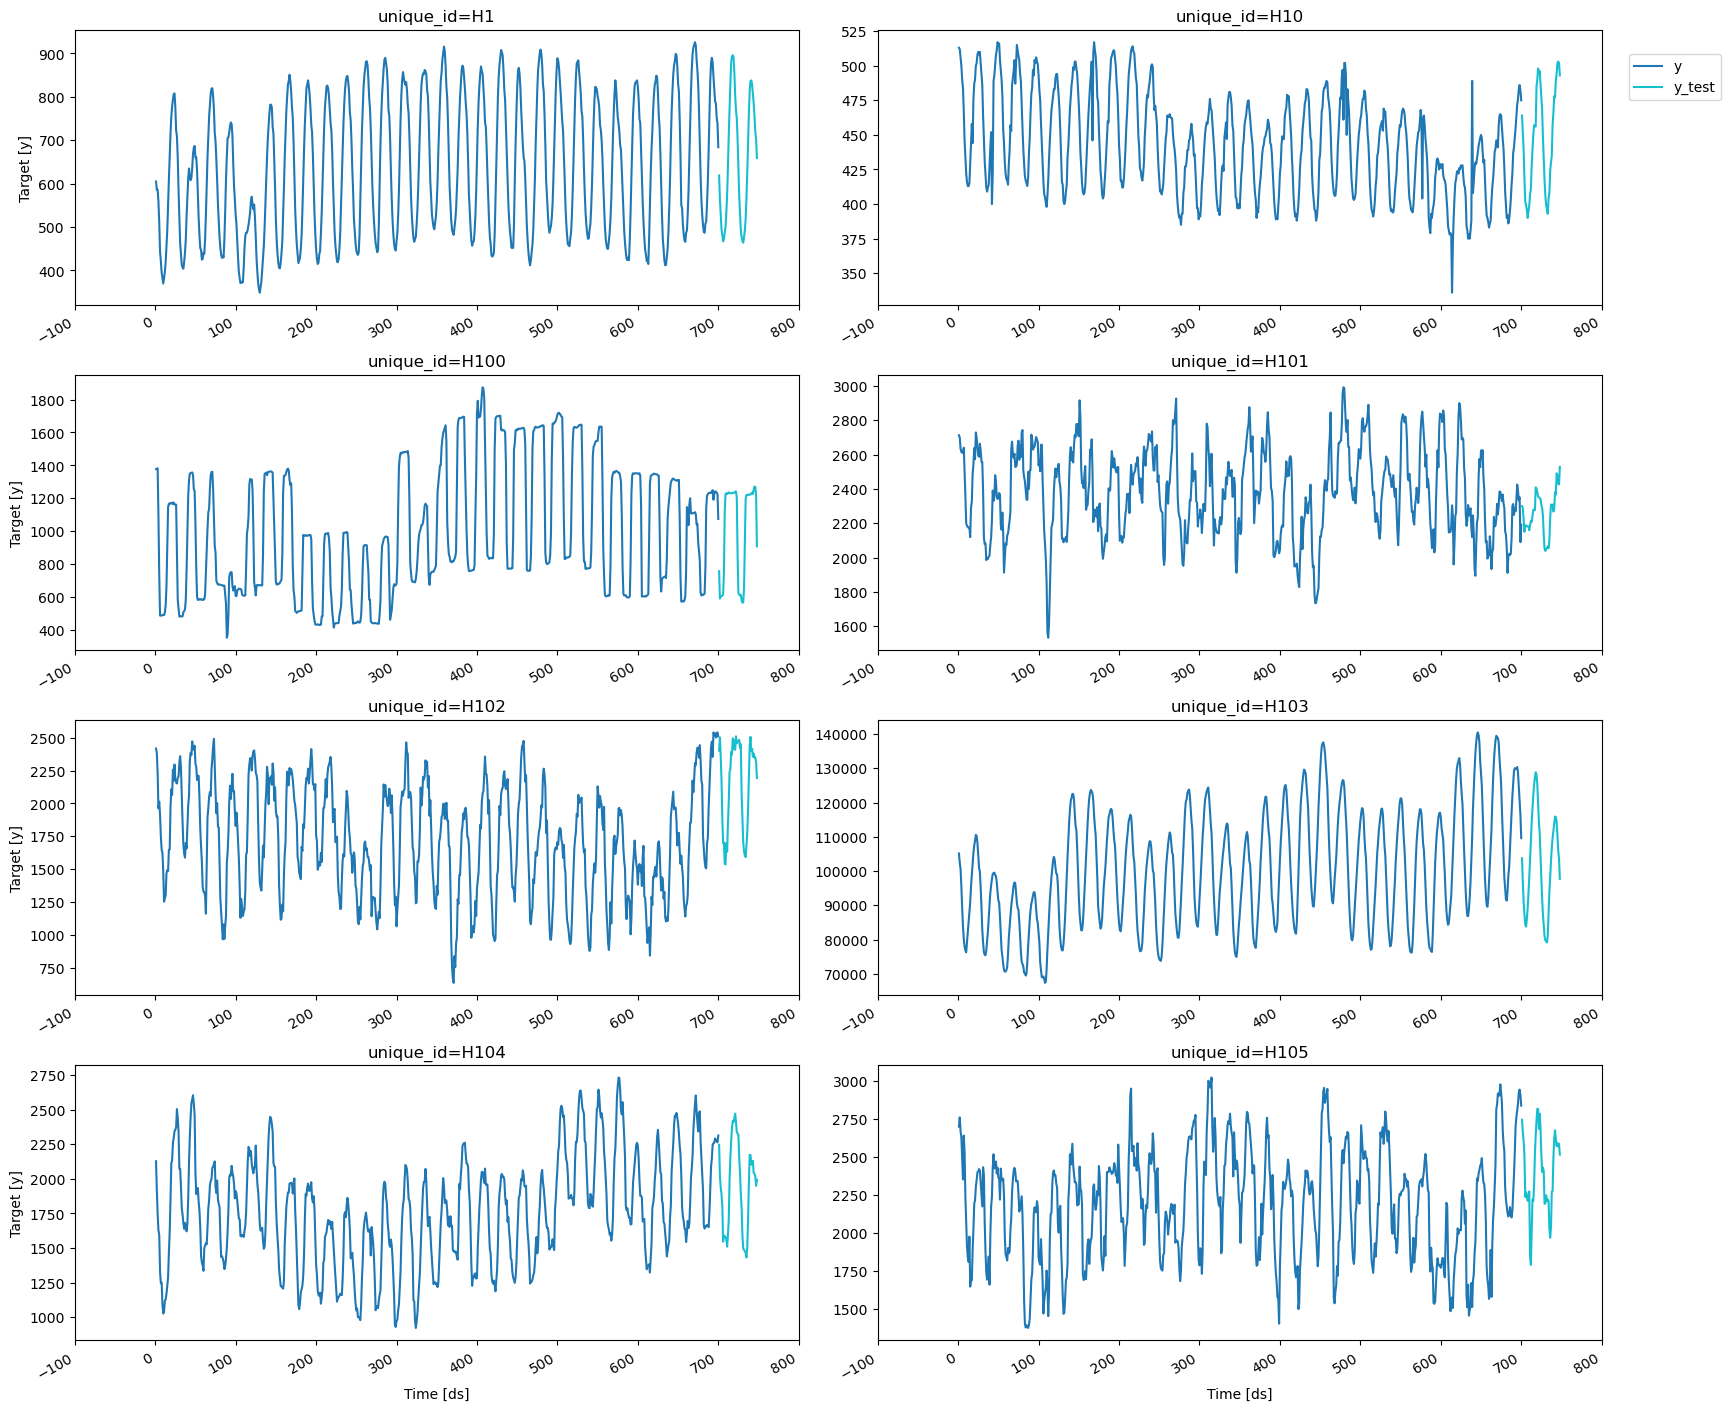

In [14]:
fig

### 3. Train models
MLForecast can train multiple models that follow the sklearn syntax (fit and predict) on different time series efficiently.

In [27]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [28]:
# Create a list of models and instantiation parameters 
models = [
    KNeighborsRegressor(),
    Lasso(),
    LinearRegression(),
    MLPRegressor(),
    Ridge(),
]

In [30]:
# crear objeto de mlforecast para hacer forecast
mlf = MLForecast(
    models=[Ridge(), Lasso(), LinearRegression(), KNeighborsRegressor(), MLPRegressor(random_state=0)],
    freq=1,
    target_transforms=[Differences([1])],
    #lags=[24 * (i+1) for i in range(7)], # original notebook
    lags = [2, 4, 6] # agregar 3 lags
)

In [31]:
mlf

MLForecast(models=[Ridge, Lasso, LinearRegression, KNeighborsRegressor, MLPRegressor], freq=1, lag_features=['lag2', 'lag4', 'lag6'], date_features=[], num_threads=1)

Now we’re ready to generate the point forecasts and the prediction intervals. To do this, we’ll use the fit method, which takes the following arguments:

- data: Series data in long format.
- id_col: Column that identifies each series. In our case, unique_id.
- time_col: Column that identifies each timestep, its values can be timestamps or integers. In our case, ds.
- target_col: Column that contains the target. In our case, y.
- prediction_intervals: A PredicitonIntervals class. The class takes two parameters: n_windows and h. n_windows represents the number of cross-validatio,n windows used to calibrate the intervals and h is the forecast horizon. The strategy will adjust the intervals for each horizon step, resulting in different widths for each step.

- **prediction_intervals: una clase PredicitonIntervals. La clase toma dos parámetros: n_windows y h.**

n_windows representa la cantidad de ventanas de validación cruzada utilizadas para calibrar los intervalos y 

h es el horizonte de pronóstico. 

La estrategia ajustará los intervalos para cada paso del horizonte, lo que dará como resultado diferentes anchos para cada paso.

In [47]:
# show train dataframe
train

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
5595,H105,696,2849.0
5596,H105,697,2921.0
5597,H105,698,2941.0
5598,H105,699,2905.0


In [34]:
# entrenar modelo
mlf.fit(
    train,
    prediction_intervals=PredictionIntervals(n_windows=10, h=48),
)

/opt/anaconda3/envs/ds-timeseries-fcst/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLForecast(models=[Ridge, Lasso, LinearRegression, KNeighborsRegressor, MLPRegressor], freq=1, lag_features=['lag2', 'lag4', 'lag6'], date_features=[], num_threads=1)

After fitting the models, we will call the predict method to generate forecasts with prediction intervals. The method takes the following arguments:

- horizon: An integer that represent the forecasting horizon. In this case, we’ll forecast the next 48 hours.
- level: A list of floats with the confidence levels of the prediction intervals. For example, level=[95] means that the range of values should include the actual future value with probability 95%.

In [35]:
levels = [50, 80, 95]
forecasts = mlf.predict(48, level=levels)

In [36]:
forecasts.head()

,unique_id,ds,Ridge,Lasso,LinearRegression,KNeighborsRegressor,MLPRegressor,Ridge-lo-95,Ridge-lo-80,Ridge-lo-50,...,KNeighborsRegressor-lo-50,KNeighborsRegressor-hi-50,KNeighborsRegressor-hi-80,KNeighborsRegressor-hi-95,MLPRegressor-lo-95,MLPRegressor-lo-80,MLPRegressor-lo-50,MLPRegressor-hi-50,MLPRegressor-hi-80,MLPRegressor-hi-95
0,H1,701,689.175267,689.175203,689.175267,747.8,687.133281,623.112976,628.015002,637.182828,...,705.55,790.05,816.26,818.690,623.550616,631.807511,643.331347,730.935216,742.459052,750.715947
1,H1,702,654.567594,654.567509,654.567594,739.0,655.747611,535.580002,562.667096,571.614491,...,670.15,807.85,845.08,873.325,548.442180,570.331627,581.179911,730.315310,741.163595,763.053042
2,H1,703,661.505303,661.505194,661.505303,768.0,658.807500,489.746877,509.378258,534.127462,...,639.85,896.15,929.62,950.515,497.083888,523.039088,545.318744,772.296256,794.575913,820.531113
3,H1,704,640.010824,640.010764,640.010824,745.8,649.686326,438.005913,464.048606,499.791911,...,606.60,885.00,907.88,949.070,460.422413,485.197106,525.103940,774.268713,814.175547,838.950240
4,H1,705,656.613992,656.613849,656.613992,831.2,655.815675,405.103067,442.192710,474.859204,...,663.25,999.15,1054.44,1086.570,434.479928,465.340543,505.122729,806.508621,846.290807,877.151422


In [37]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

In [38]:
test.head()

,unique_id,ds,y,Ridge,Lasso,LinearRegression,KNeighborsRegressor,MLPRegressor,Ridge-lo-95,Ridge-lo-80,...,KNeighborsRegressor-lo-50,KNeighborsRegressor-hi-50,KNeighborsRegressor-hi-80,KNeighborsRegressor-hi-95,MLPRegressor-lo-95,MLPRegressor-lo-80,MLPRegressor-lo-50,MLPRegressor-hi-50,MLPRegressor-hi-80,MLPRegressor-hi-95
0,H1,701,619.0,689.175267,689.175203,689.175267,747.8,687.133281,623.112976,628.015002,...,705.55,790.05,816.26,818.690,623.550616,631.807511,643.331347,730.935216,742.459052,750.715947
1,H1,702,565.0,654.567594,654.567509,654.567594,739.0,655.747611,535.580002,562.667096,...,670.15,807.85,845.08,873.325,548.442180,570.331627,581.179911,730.315310,741.163595,763.053042
2,H1,703,532.0,661.505303,661.505194,661.505303,768.0,658.807500,489.746877,509.378258,...,639.85,896.15,929.62,950.515,497.083888,523.039088,545.318744,772.296256,794.575913,820.531113
3,H1,704,495.0,640.010824,640.010764,640.010824,745.8,649.686326,438.005913,464.048606,...,606.60,885.00,907.88,949.070,460.422413,485.197106,525.103940,774.268713,814.175547,838.950240
4,H1,705,481.0,656.613992,656.613849,656.613992,831.2,655.815675,405.103067,442.192710,...,663.25,999.15,1054.44,1086.570,434.479928,465.340543,505.122729,806.508621,846.290807,877.151422


### 3.x Extra - realizar inferencia con modelo base
Generar una instancia y realizar predicción

In [61]:
# generar instancia para predecir
instance_raw = mlf.preprocess(train).tail(1)
instance = instance_raw[['lag2', 'lag4','lag6']]
instance

,lag2,lag4,lag6
5599,20.0,44.0,62.0


In [62]:
# hacer inferencia con modelo base con instancia
mlf.models_['Ridge'].predict(instance)

array([-6.30963516])

### 4. Plot prediction intervals
To plot the point and the prediction intervals, we’ll use the plot_series function again. Notice that now we also need to specify the model and the levels that we want to plot.

In [39]:
levels

[50, 80, 95]

#### KNN prediction intervals

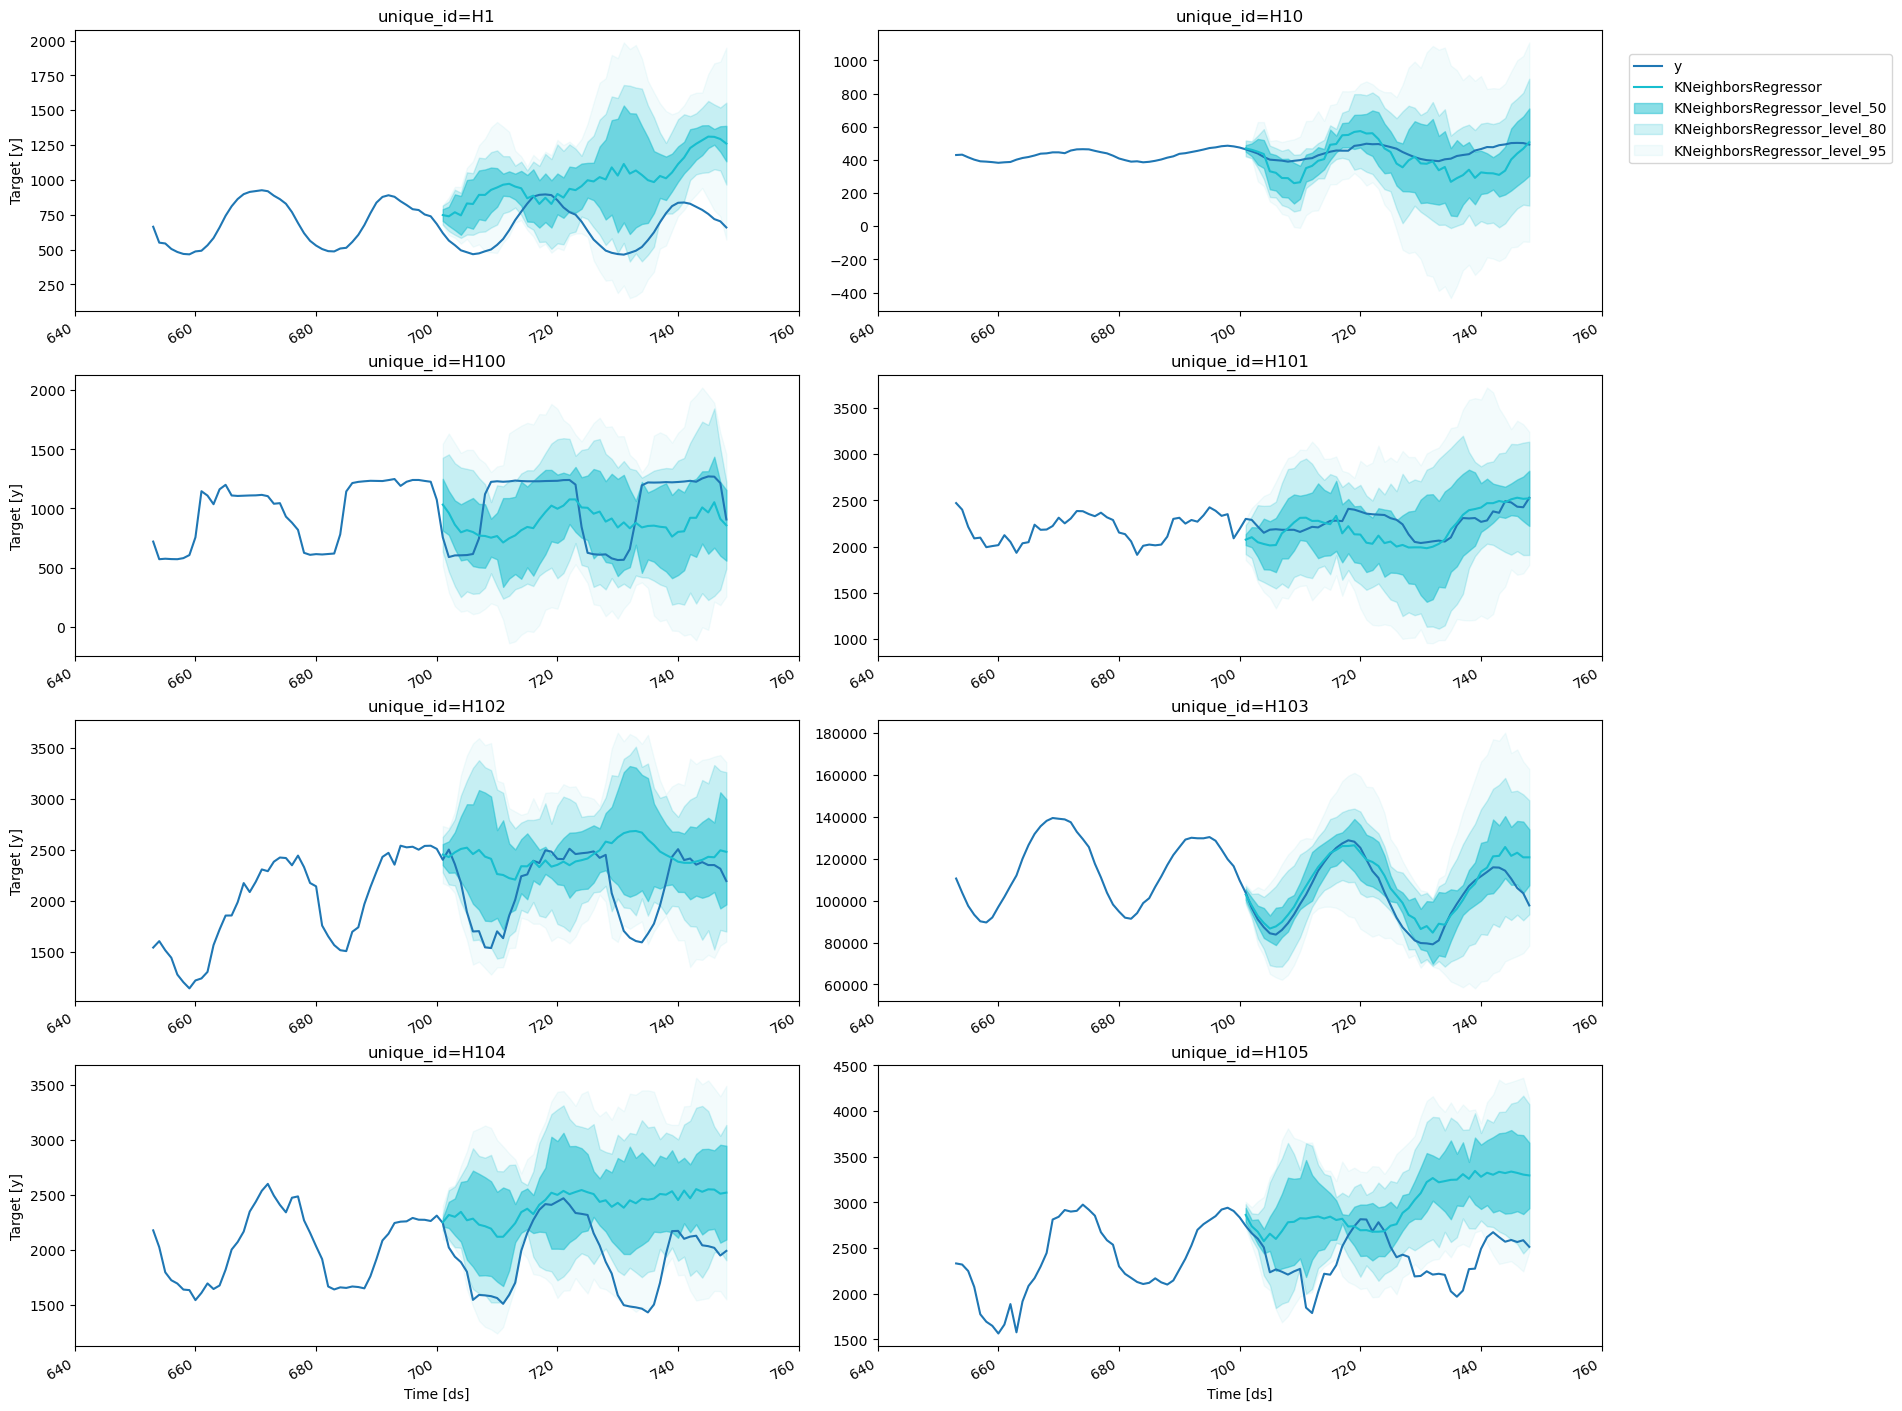

In [40]:
fig = plot_series(
    train, 
    test, 
    plot_random=False, 
    models=['KNeighborsRegressor'], 
    level=levels, 
    max_insample_length=48
)
fig

#### Lasso prediction intervals

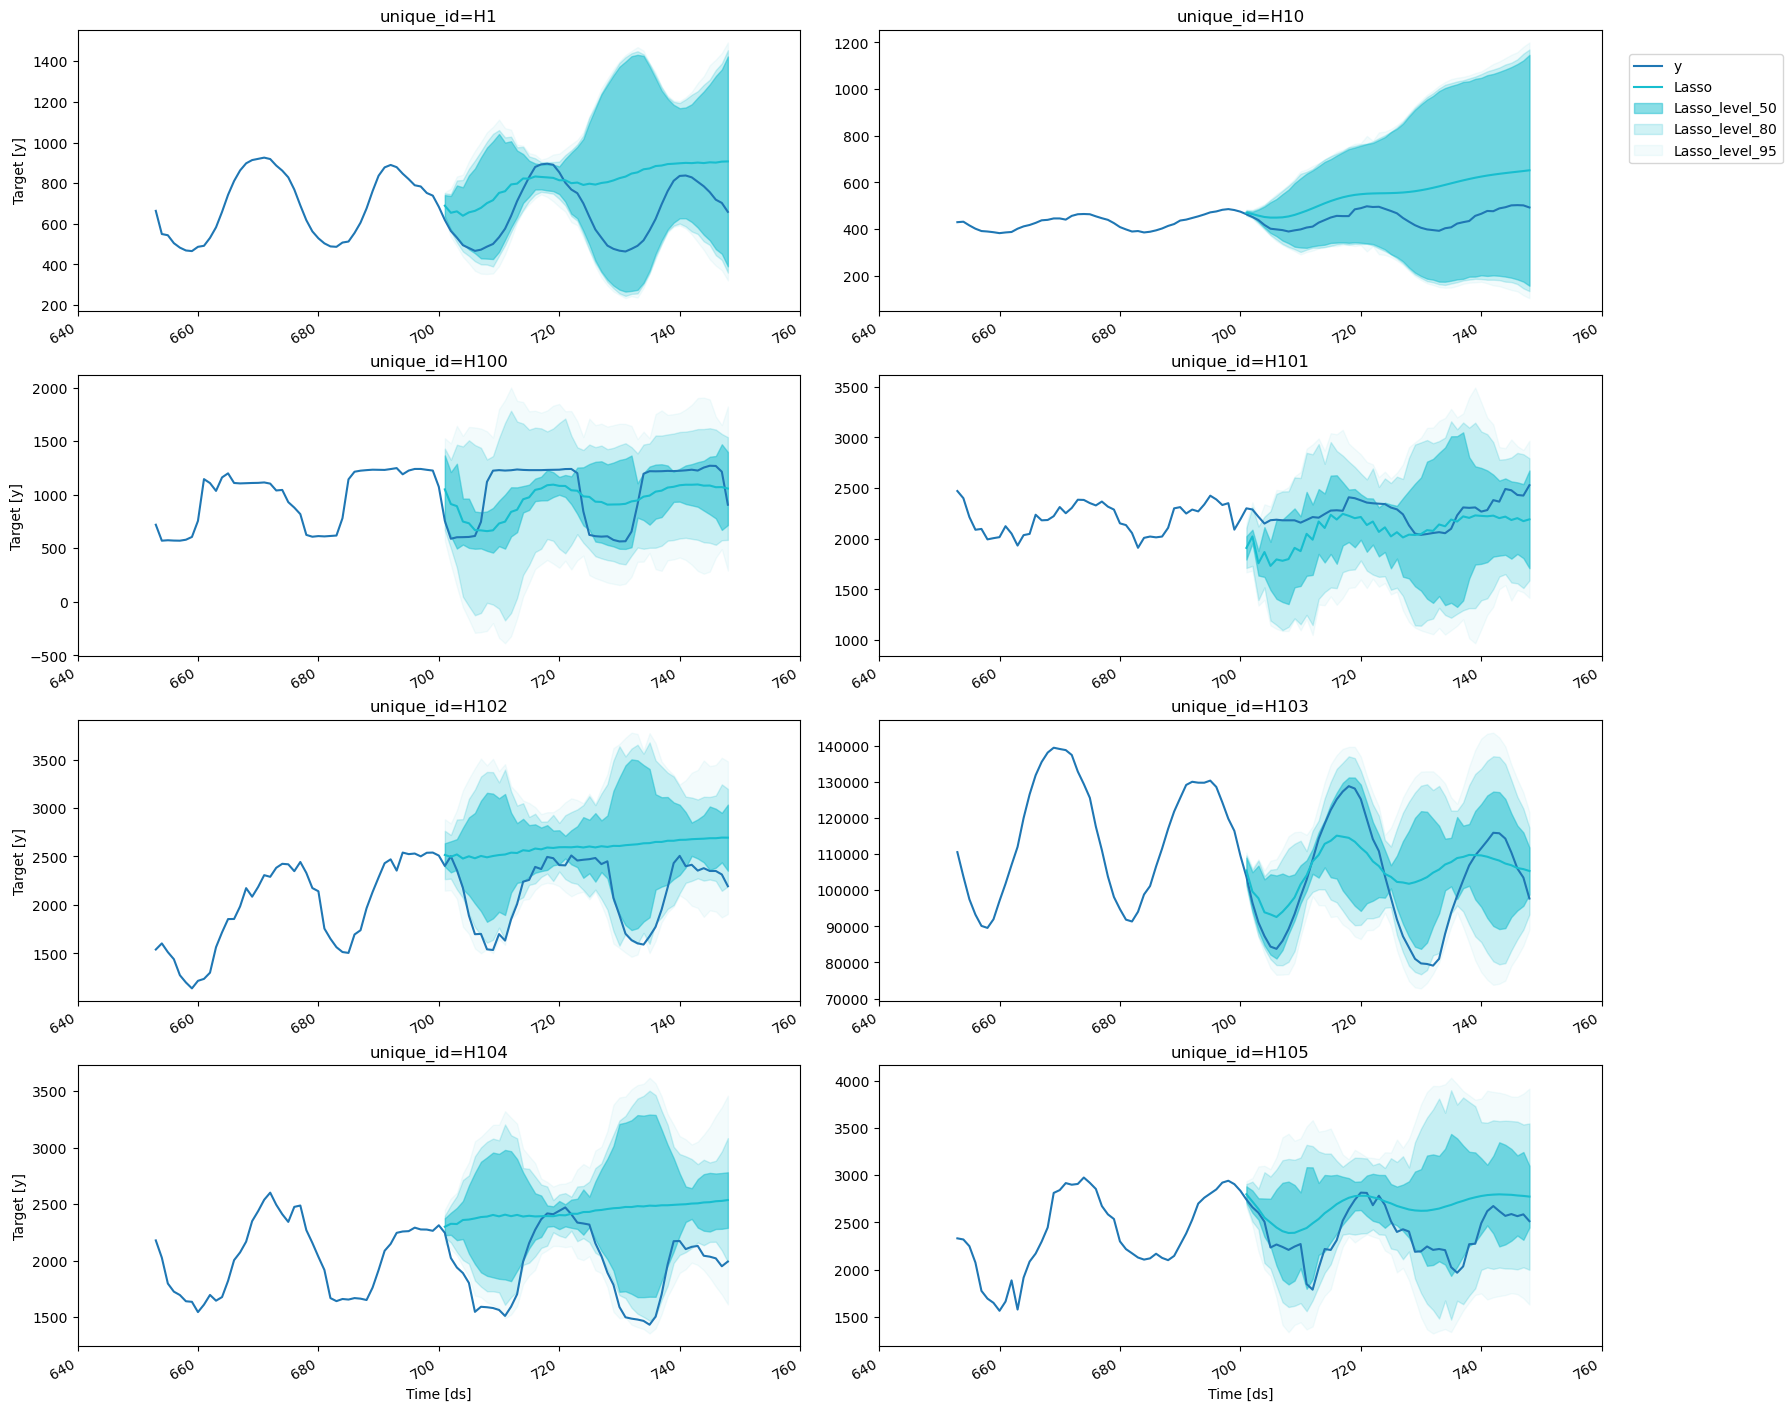

In [42]:
fig = plot_series(
    train, 
    test, 
    plot_random=False, 
    models=['Lasso'],
    level=levels, 
    max_insample_length=48
)
fig

#### linear regression prediction intervals

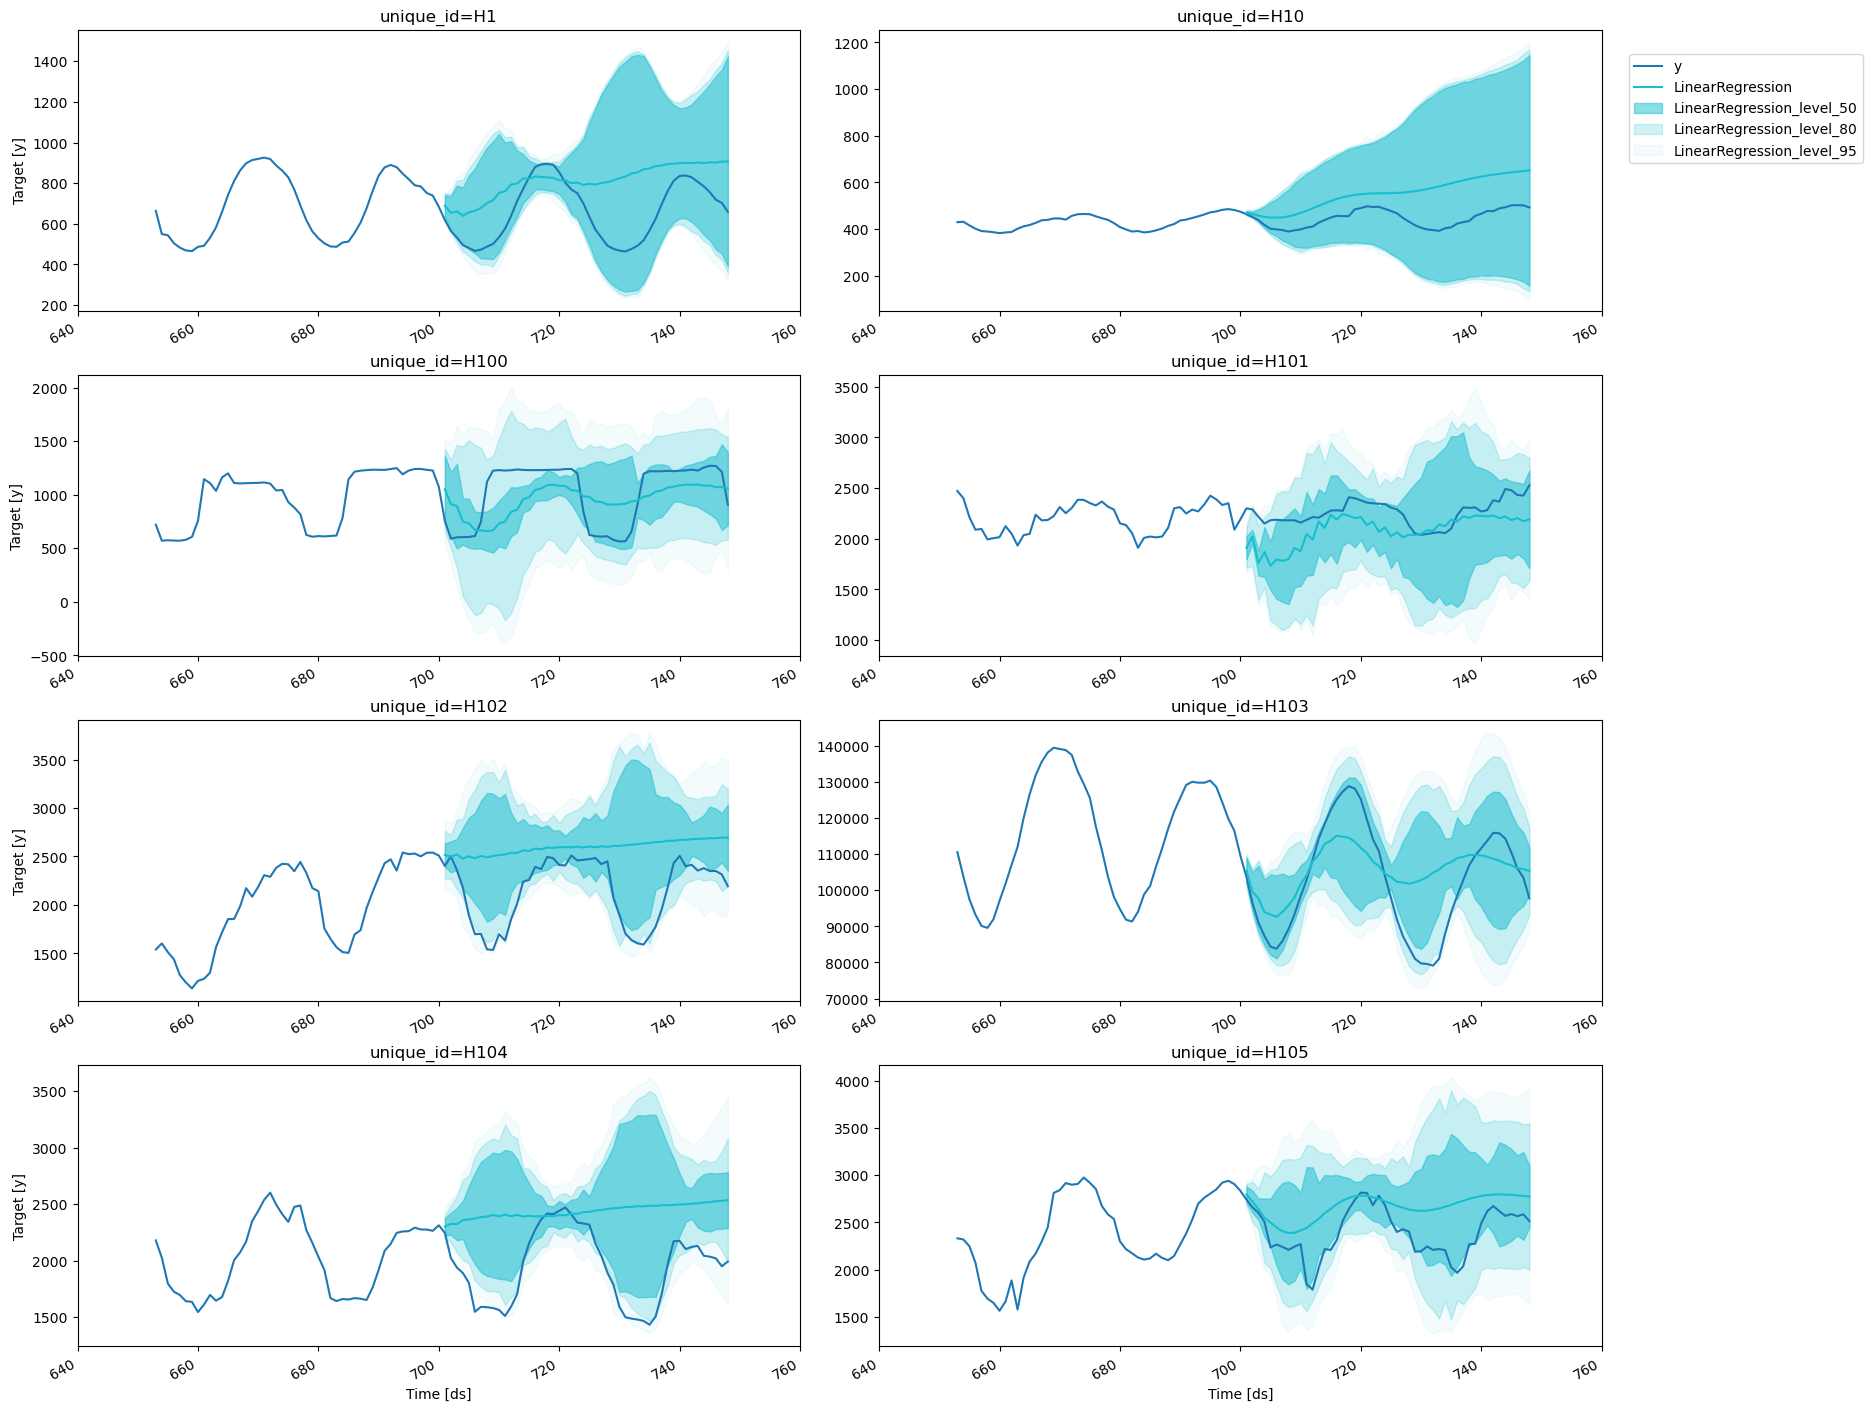

In [43]:
fig = plot_series(
    train, 
    test, 
    plot_random=False, 
    models=['LinearRegression'],
    level=levels, 
    max_insample_length=48
)
fig

### MLP prediction intervals

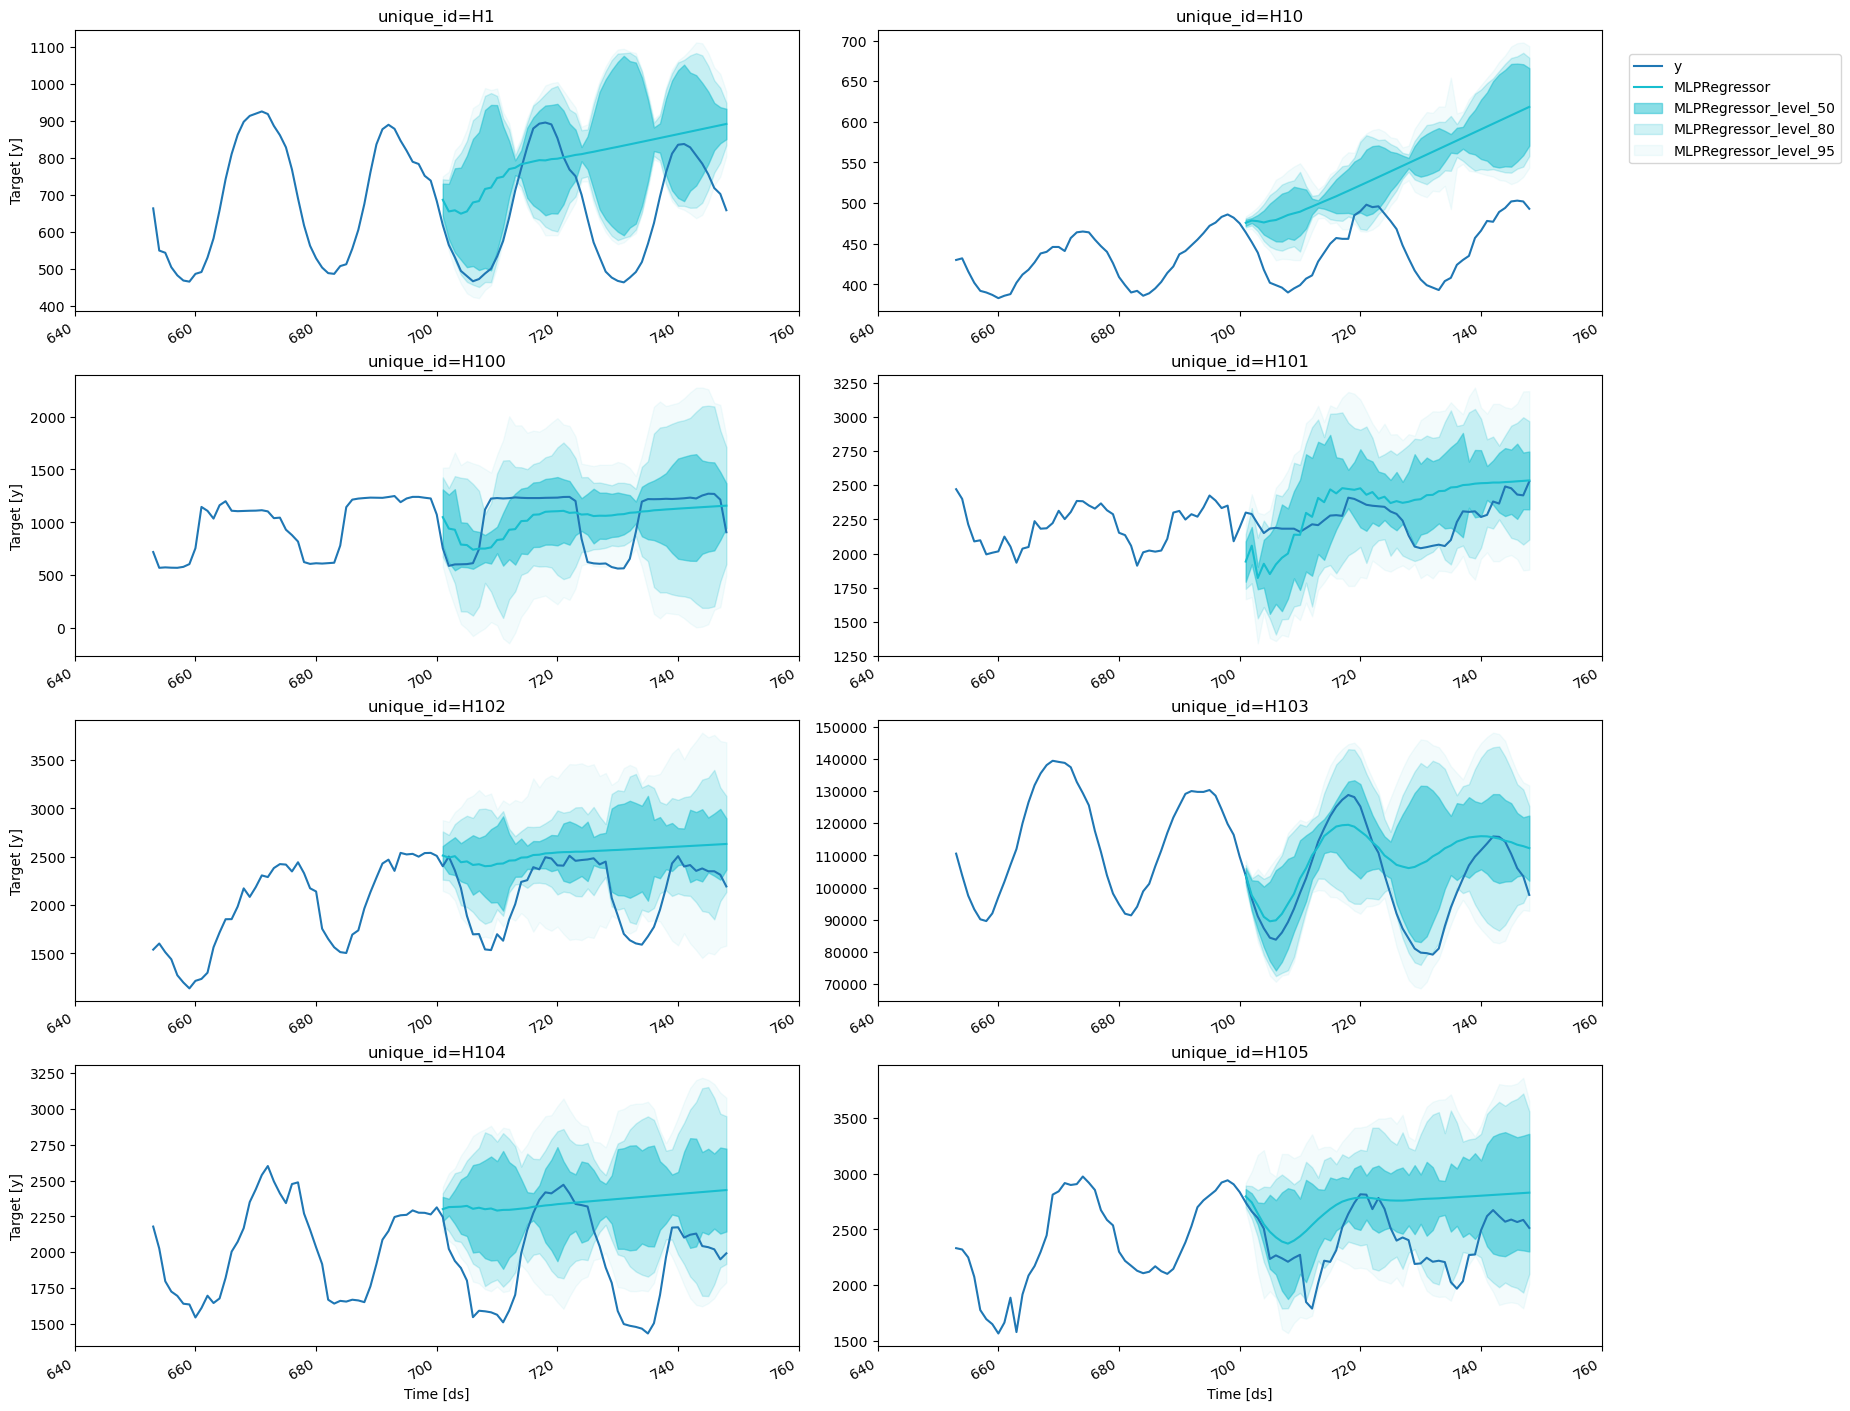

In [44]:
fig = plot_series(
    train, 
    test, 
    plot_random=False, 
    models=['MLPRegressor'],
    level=levels, 
    max_insample_length=48
)
fig

#### ridge prediction intervals

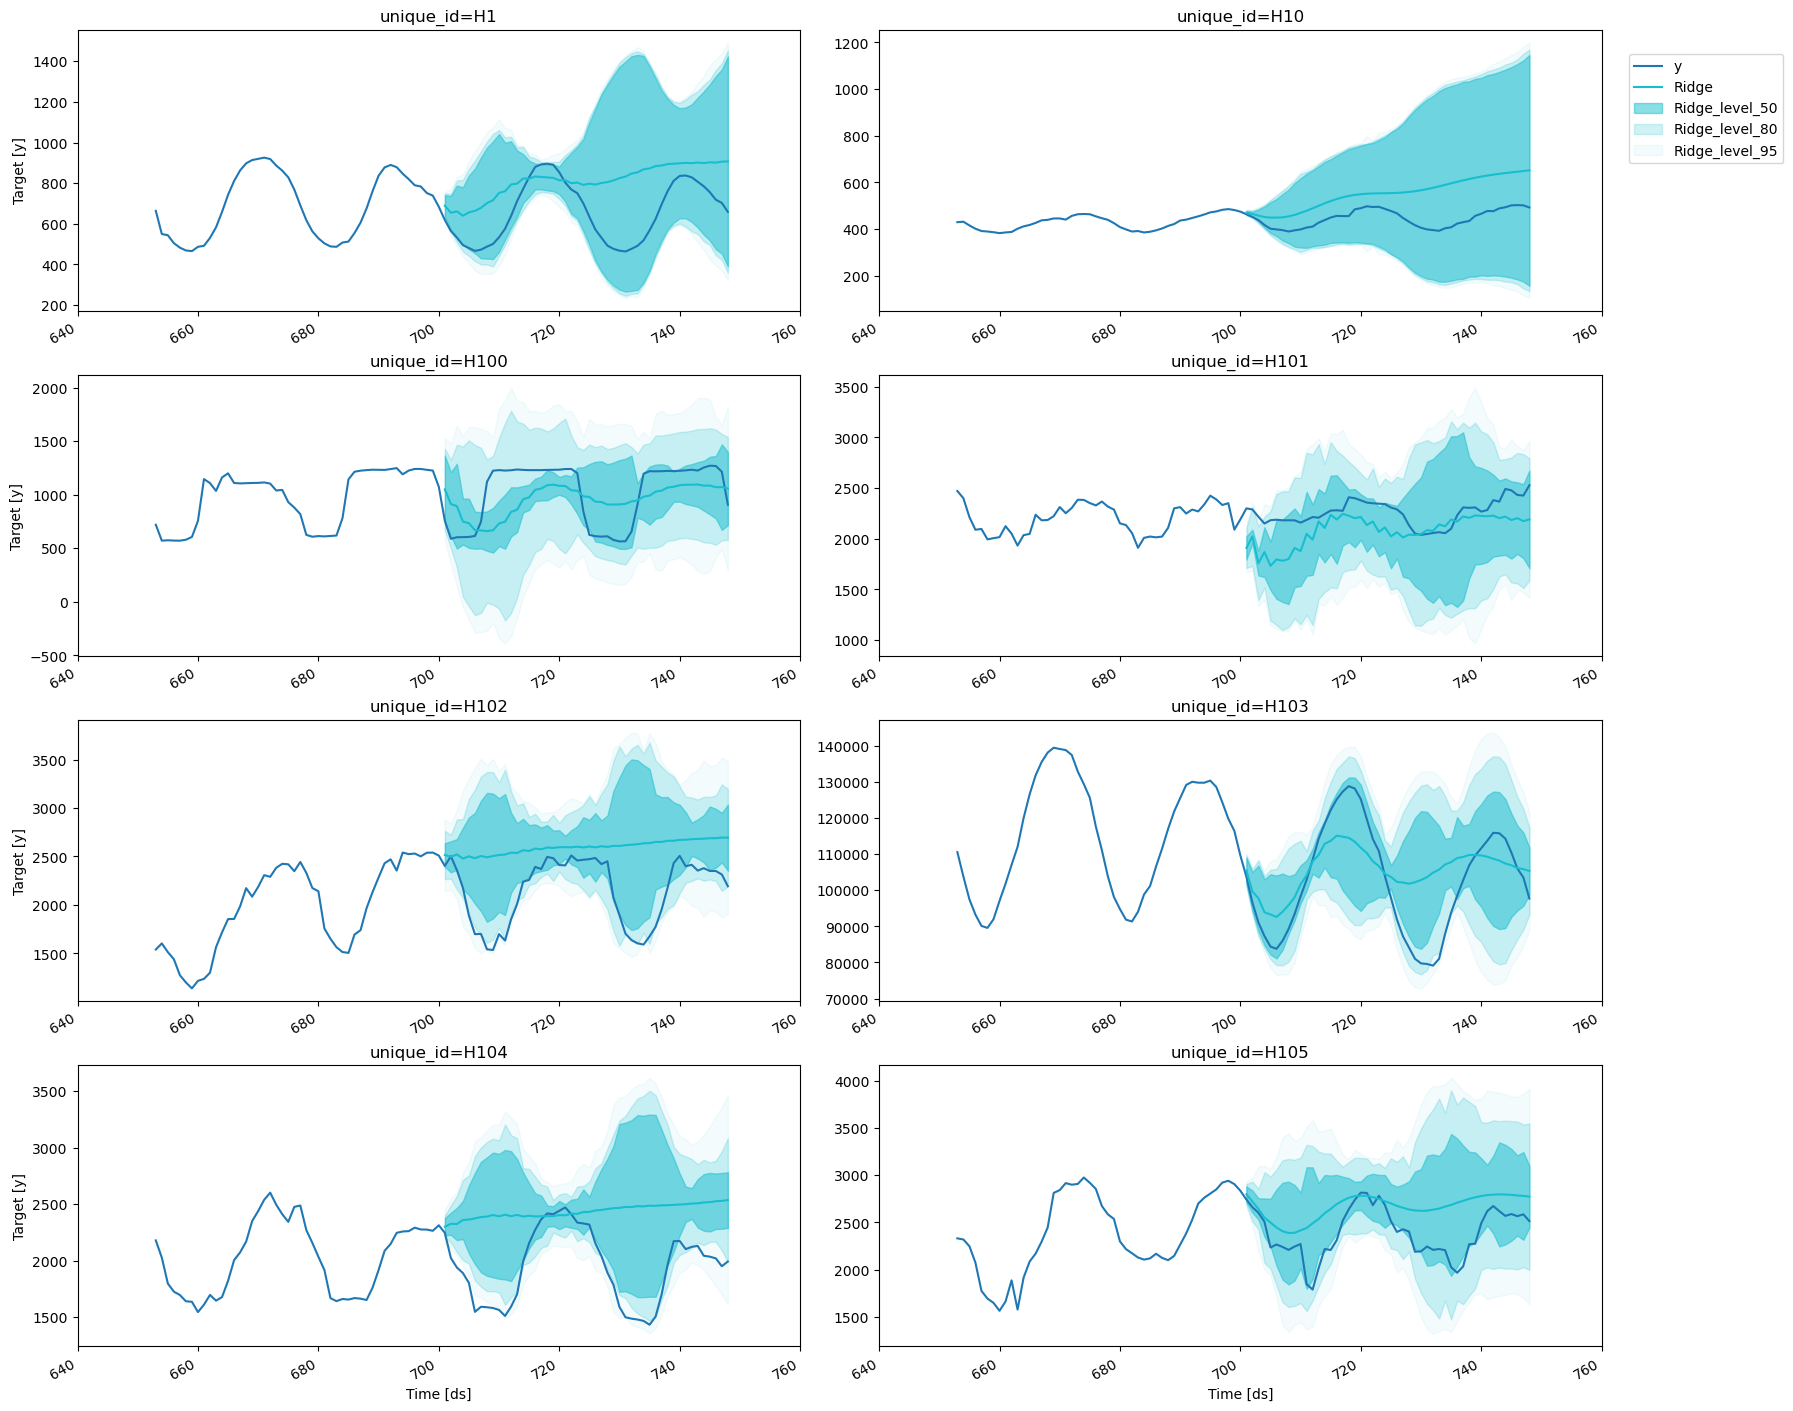

In [46]:
fig = plot_series(
    train, 
    test, 
    plot_random=False, 
    models=['Ridge'],
    level=levels, 
    max_insample_length=48
)
fig

### REFERENCES

- Kamile Stankeviciute, Ahmed M. Alaa and Mihaela van der Schaar (2021). “Conformal Time-Series Forecasting”
https://proceedings.neurips.cc/paper/2021/file/312f1ba2a72318edaaa995a67835fad5-Paper.pdf

- Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, The Statistical Forecasting Perspective”.
https://otexts.com/fpp3/perspective.html